In [1]:
# ! pip install catboost

In [21]:
import os

import pandas as pd
import numpy as np
import collections

import json

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil import parser

from sklearn import preprocessing
from tqdm import tqdm

from joblib import Parallel, delayed

import collections

import pickle

from sklearn import metrics

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV 

from sklearn.metrics import classification_report

import requests

from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('./dataset.csv').drop('Unnamed: 0', axis=1)

In [5]:
df.head()

,light,region,address,category,datetime,severity,dead_count,injured_count,parent_region,participants_count,...,road_conditions-40,road_conditions-27,participant_categories-0,participant_categories-5,participant_categories-2,participant_categories-3,participant_categories-4,participant_categories-1,index_,cluster
0,2,821,4650,17,2018-12-08 00:20:00,2,0,1,8,1,...,0,0,0,0,0,0,0,1,2763.519748,Без угроз для здоровья
1,0,826,1589,16,2018-09-16 00:20:00,1,1,5,26,7,...,1,0,0,0,0,0,0,1,25040.536616,Без угроз для здоровья
2,4,134,7356,15,2016-06-29 15:50:00,0,0,1,9,2,...,1,0,0,0,0,0,0,1,98663.156313,Угроза здоровью
3,4,153,1737,16,2019-09-21 11:00:00,2,0,4,25,4,...,0,0,0,0,1,0,0,1,485263.313916,Без угроз для здоровья
4,4,269,2203,9,2020-05-12 19:20:00,2,0,1,0,2,...,1,0,0,1,1,0,0,1,385579.301741,Без угроз для здоровья


# Task 1: Визуализация

In [6]:
def cor(train):
    plt.figure(figsize = (16, 6))
    sns.heatmap(train.corr(), 
                annot = True,
                fmt = '.2f',
                square = True,
                cmap = "Blues_r", 
                mask = np.triu(train.corr()))

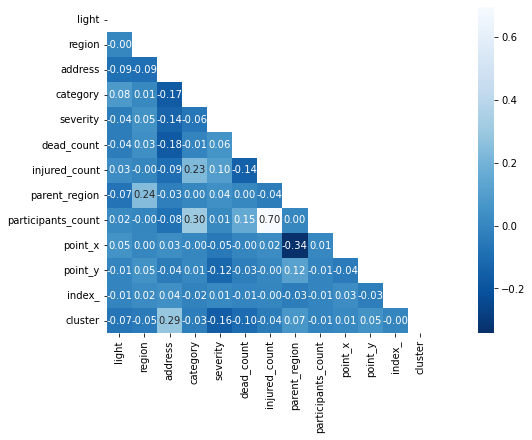

In [7]:
corr_df = df.drop(
    [col for col in df.columns if col.find('tags') == 0 or col.find('nearby') == 0 or col.find('road_conditions') == 0 or col.find('participant_categories') == 0 or col.find('weather') == 0],   
    axis = 1
)

def rename_cluster(x):
    if x == "Без угроз для здоровья":
        return 0
    elif x == "Угроза здоровью":
        return 1
    elif x == "Максимальная опасность":
        return 2
    
corr_df['cluster'] = corr_df['cluster'].apply(lambda x: rename_cluster(x))
cor(corr_df)

Исходя из результатов корреляции Пирсона большее влияние на определение уровня опасности оказывает адресс (атрибут address)

# Task 2: Выбор модели классификации

In [8]:
df_train = pd.read_csv('train_df.csv').drop(['datetime'], axis=1)
df_test = pd.read_csv('test_df.csv').drop(['datetime'], axis=1)

In [9]:
X_train = df_train.drop(['cluster'], axis=1)
y_train = df_train['cluster']

X_test = df_test.drop(['cluster'], axis=1)
y_test = df_test['cluster']

Модели для выбора я подобрал разной сложности:

1. LogisticRegression
2. RandomForestClassifier
3. CatBoostClassifier

Чтобы выбрать модель я буду использовать метрики:
1. F1-score
2. precision
3. recall
4. accurasy

In [10]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

cb = CatBoostClassifier(random_state=0)
cb.fit(X_train, y_train)

Learning rate set to 0.105465
0:	learn: 0.9257569	total: 175ms	remaining: 2m 55s
1:	learn: 0.7988543	total: 223ms	remaining: 1m 51s
2:	learn: 0.6997994	total: 275ms	remaining: 1m 31s
3:	learn: 0.6208619	total: 324ms	remaining: 1m 20s
4:	learn: 0.5562898	total: 370ms	remaining: 1m 13s
5:	learn: 0.5021722	total: 432ms	remaining: 1m 11s
6:	learn: 0.4567622	total: 476ms	remaining: 1m 7s
7:	learn: 0.4166984	total: 526ms	remaining: 1m 5s
8:	learn: 0.3832331	total: 571ms	remaining: 1m 2s
9:	learn: 0.3534322	total: 638ms	remaining: 1m 3s
10:	learn: 0.3279622	total: 690ms	remaining: 1m 2s
11:	learn: 0.3064340	total: 729ms	remaining: 1m
12:	learn: 0.2873118	total: 771ms	remaining: 58.5s
13:	learn: 0.2703248	total: 819ms	remaining: 57.7s
14:	learn: 0.2552960	total: 866ms	remaining: 56.9s
15:	learn: 0.2415035	total: 925ms	remaining: 56.9s
16:	learn: 0.2298668	total: 974ms	remaining: 56.3s
17:	learn: 0.2194420	total: 1.02s	remaining: 55.5s
18:	learn: 0.2082538	total: 1.07s	remaining: 55.1s
19:	lear

162:	learn: 0.0551102	total: 8.37s	remaining: 43s
163:	learn: 0.0550281	total: 8.41s	remaining: 42.9s
164:	learn: 0.0548925	total: 8.46s	remaining: 42.8s
165:	learn: 0.0546628	total: 8.53s	remaining: 42.9s
166:	learn: 0.0545013	total: 8.58s	remaining: 42.8s
167:	learn: 0.0543519	total: 8.63s	remaining: 42.7s
168:	learn: 0.0541639	total: 8.68s	remaining: 42.7s
169:	learn: 0.0540190	total: 8.77s	remaining: 42.8s
170:	learn: 0.0538676	total: 8.82s	remaining: 42.8s
171:	learn: 0.0537730	total: 8.85s	remaining: 42.6s
172:	learn: 0.0535970	total: 8.9s	remaining: 42.5s
173:	learn: 0.0534994	total: 8.95s	remaining: 42.5s
174:	learn: 0.0533808	total: 9s	remaining: 42.4s
175:	learn: 0.0532477	total: 9.04s	remaining: 42.3s
176:	learn: 0.0530810	total: 9.09s	remaining: 42.3s
177:	learn: 0.0528867	total: 9.13s	remaining: 42.2s
178:	learn: 0.0527293	total: 9.18s	remaining: 42.1s
179:	learn: 0.0526190	total: 9.22s	remaining: 42s
180:	learn: 0.0525204	total: 9.28s	remaining: 42s
181:	learn: 0.0524139	

324:	learn: 0.0406282	total: 16.5s	remaining: 34.3s
325:	learn: 0.0405625	total: 16.6s	remaining: 34.3s
326:	learn: 0.0405120	total: 16.6s	remaining: 34.2s
327:	learn: 0.0404592	total: 16.7s	remaining: 34.2s
328:	learn: 0.0403672	total: 16.7s	remaining: 34.1s
329:	learn: 0.0403470	total: 16.8s	remaining: 34.1s
330:	learn: 0.0403016	total: 16.8s	remaining: 34s
331:	learn: 0.0402309	total: 16.9s	remaining: 34s
332:	learn: 0.0401928	total: 16.9s	remaining: 33.9s
333:	learn: 0.0401375	total: 17s	remaining: 33.9s
334:	learn: 0.0400689	total: 17s	remaining: 33.8s
335:	learn: 0.0399734	total: 17.1s	remaining: 33.8s
336:	learn: 0.0399278	total: 17.1s	remaining: 33.7s
337:	learn: 0.0398888	total: 17.2s	remaining: 33.6s
338:	learn: 0.0398232	total: 17.2s	remaining: 33.6s
339:	learn: 0.0397710	total: 17.3s	remaining: 33.5s
340:	learn: 0.0397072	total: 17.3s	remaining: 33.5s
341:	learn: 0.0396385	total: 17.4s	remaining: 33.4s
342:	learn: 0.0396012	total: 17.4s	remaining: 33.4s
343:	learn: 0.039564

486:	learn: 0.0341555	total: 24.7s	remaining: 26s
487:	learn: 0.0341039	total: 24.7s	remaining: 26s
488:	learn: 0.0340765	total: 24.8s	remaining: 25.9s
489:	learn: 0.0340358	total: 24.8s	remaining: 25.9s
490:	learn: 0.0339977	total: 24.9s	remaining: 25.8s
491:	learn: 0.0339817	total: 24.9s	remaining: 25.8s
492:	learn: 0.0339679	total: 25s	remaining: 25.7s
493:	learn: 0.0339511	total: 25s	remaining: 25.6s
494:	learn: 0.0339211	total: 25.1s	remaining: 25.6s
495:	learn: 0.0338748	total: 25.1s	remaining: 25.6s
496:	learn: 0.0338142	total: 25.2s	remaining: 25.5s
497:	learn: 0.0337874	total: 25.2s	remaining: 25.4s
498:	learn: 0.0337524	total: 25.3s	remaining: 25.4s
499:	learn: 0.0337068	total: 25.4s	remaining: 25.4s
500:	learn: 0.0336737	total: 25.4s	remaining: 25.3s
501:	learn: 0.0336567	total: 25.4s	remaining: 25.2s
502:	learn: 0.0336176	total: 25.5s	remaining: 25.2s
503:	learn: 0.0335926	total: 25.5s	remaining: 25.1s
504:	learn: 0.0335496	total: 25.6s	remaining: 25.1s
505:	learn: 0.033527

645:	learn: 0.0302408	total: 32.8s	remaining: 18s
646:	learn: 0.0302126	total: 32.9s	remaining: 17.9s
647:	learn: 0.0301933	total: 32.9s	remaining: 17.9s
648:	learn: 0.0301708	total: 33s	remaining: 17.8s
649:	learn: 0.0301567	total: 33s	remaining: 17.8s
650:	learn: 0.0301412	total: 33.1s	remaining: 17.7s
651:	learn: 0.0301180	total: 33.1s	remaining: 17.7s
652:	learn: 0.0301089	total: 33.2s	remaining: 17.6s
653:	learn: 0.0300894	total: 33.2s	remaining: 17.6s
654:	learn: 0.0300640	total: 33.3s	remaining: 17.5s
655:	learn: 0.0300527	total: 33.3s	remaining: 17.5s
656:	learn: 0.0300415	total: 33.4s	remaining: 17.4s
657:	learn: 0.0300140	total: 33.4s	remaining: 17.4s
658:	learn: 0.0300033	total: 33.5s	remaining: 17.3s
659:	learn: 0.0299894	total: 33.5s	remaining: 17.3s
660:	learn: 0.0299650	total: 33.6s	remaining: 17.2s
661:	learn: 0.0299323	total: 33.6s	remaining: 17.2s
662:	learn: 0.0299097	total: 33.7s	remaining: 17.1s
663:	learn: 0.0298855	total: 33.7s	remaining: 17.1s
664:	learn: 0.0298

805:	learn: 0.0274601	total: 41s	remaining: 9.86s
806:	learn: 0.0274525	total: 41.1s	remaining: 9.82s
807:	learn: 0.0274334	total: 41.1s	remaining: 9.77s
808:	learn: 0.0274236	total: 41.2s	remaining: 9.72s
809:	learn: 0.0274100	total: 41.2s	remaining: 9.66s
810:	learn: 0.0273920	total: 41.3s	remaining: 9.61s
811:	learn: 0.0273820	total: 41.3s	remaining: 9.56s
812:	learn: 0.0273691	total: 41.3s	remaining: 9.51s
813:	learn: 0.0273538	total: 41.4s	remaining: 9.46s
814:	learn: 0.0273461	total: 41.5s	remaining: 9.41s
815:	learn: 0.0273325	total: 41.5s	remaining: 9.36s
816:	learn: 0.0273236	total: 41.6s	remaining: 9.32s
817:	learn: 0.0273150	total: 41.7s	remaining: 9.27s
818:	learn: 0.0273036	total: 41.7s	remaining: 9.22s
819:	learn: 0.0272917	total: 41.8s	remaining: 9.16s
820:	learn: 0.0272752	total: 41.8s	remaining: 9.11s
821:	learn: 0.0272584	total: 41.8s	remaining: 9.06s
822:	learn: 0.0272455	total: 41.9s	remaining: 9.01s
823:	learn: 0.0272323	total: 41.9s	remaining: 8.96s
824:	learn: 0.

966:	learn: 0.0254070	total: 48.8s	remaining: 1.67s
967:	learn: 0.0254013	total: 48.9s	remaining: 1.61s
968:	learn: 0.0253904	total: 48.9s	remaining: 1.56s
969:	learn: 0.0253683	total: 49s	remaining: 1.51s
970:	learn: 0.0253514	total: 49s	remaining: 1.46s
971:	learn: 0.0253458	total: 49.1s	remaining: 1.41s
972:	learn: 0.0253359	total: 49.1s	remaining: 1.36s
973:	learn: 0.0253284	total: 49.2s	remaining: 1.31s
974:	learn: 0.0253246	total: 49.2s	remaining: 1.26s
975:	learn: 0.0253156	total: 49.3s	remaining: 1.21s
976:	learn: 0.0253031	total: 49.3s	remaining: 1.16s
977:	learn: 0.0252748	total: 49.4s	remaining: 1.11s
978:	learn: 0.0252680	total: 49.4s	remaining: 1.06s
979:	learn: 0.0252430	total: 49.4s	remaining: 1.01s
980:	learn: 0.0252321	total: 49.5s	remaining: 959ms
981:	learn: 0.0252055	total: 49.5s	remaining: 908ms
982:	learn: 0.0251979	total: 49.6s	remaining: 858ms
983:	learn: 0.0251847	total: 49.6s	remaining: 807ms
984:	learn: 0.0251630	total: 49.7s	remaining: 757ms
985:	learn: 0.02

In [11]:
def pred(estimators):
    labels = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']
    
    clusters = df['cluster'].unique()
    
    y_pred = []
    
    for idx, model in enumerate(estimators):
        print()
        print('-------------------------------------------------------------------')
        print(labels[idx])
        print('-------------------------------------------------------------------')
        y_pred.append(model.predict(X_test))
        print(classification_report(y_test, y_pred[idx], labels=clusters))
        print('-------------------------------------------------------------------')

In [12]:
estimators = [lr, rf, cb]
pred(estimators)


-------------------------------------------------------------------
LogisticRegression
-------------------------------------------------------------------
                        precision    recall  f1-score   support

Без угроз для здоровья       0.77      0.98      0.86    106064
       Угроза здоровью       0.24      0.04      0.07     18623
Максимальная опасность       0.00      0.00      0.00     13094

              accuracy                           0.76    137781
             macro avg       0.34      0.34      0.31    137781
          weighted avg       0.63      0.76      0.68    137781

-------------------------------------------------------------------

-------------------------------------------------------------------
RandomForestClassifier
-------------------------------------------------------------------
                        precision    recall  f1-score   support

Без угроз для здоровья       0.98      0.99      0.99    106064
       Угроза здоровью       0.97   

Исходя из выбранных метрик лучше всего себя показала модель CatBoostClassifier для задачи определения уровня опасности дорожной ситуации относительно других моделей.

Описание показателей CatBoostClassifier:

F1-score - почти сто процетное определение классов: Угроза здоровью, Максимальная опасность и сто процетное определение класса Без угроз для здоровья.

Для метрик precision и recall примерно одинаковое хорошее соотношение угадывания в сторону positive и negative. 

accurasy - точность ~99%.

![image.png](cb.png)

# Task 3: Feature Engineering

In [31]:
parametrs = {
    'iterations': 20,
    'depth': 10,
    'grow_policy': 'Depthwise',
    'random_state': 0
}

In [29]:
X_train = X_train.drop(['Unnamed: 0'], axis=1)

KeyError: "['Unnamed: 0'] not found in axis"

In [32]:
cb = CatBoostClassifier(**parametrs)
cb.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.5
0:	learn: 0.4484916	total: 646ms	remaining: 12.3s
1:	learn: 0.2833807	total: 1.33s	remaining: 12s
2:	learn: 0.1930788	total: 2.08s	remaining: 11.8s
3:	learn: 0.1469656	total: 2.88s	remaining: 11.5s
4:	learn: 0.1207318	total: 3.73s	remaining: 11.2s
5:	learn: 0.0982174	total: 4.68s	remaining: 10.9s
6:	learn: 0.0848262	total: 5.62s	remaining: 10.4s
7:	learn: 0.0771394	total: 6.47s	remaining: 9.71s
8:	learn: 0.0702181	total: 7.38s	remaining: 9.02s
9:	learn: 0.0656476	total: 8.22s	remaining: 8.22s
10:	learn: 0.0608906	total: 9.11s	remaining: 7.45s
11:	learn: 0.0570822	total: 9.96s	remaining: 6.64s
12:	learn: 0.0551437	total: 10.7s	remaining: 5.77s
13:	learn: 0.0529393	total: 11.5s	remaining: 4.94s
14:	learn: 0.0511392	total: 12.3s	remaining: 4.09s
15:	learn: 0.0489773	total: 13.1s	remaining: 3.27s
16:	learn: 0.0472384	total: 13.9s	remaining: 2.45s
17:	learn: 0.0454519	total: 14.7s	remaining: 1.64s
18:	learn: 0.0442215	total: 15.4s	remaining: 813ms
19:	learn: 0.04352

In [15]:
clusters = df['cluster'].unique()
y_pred = cb.predict(X_test)
print(classification_report(y_test, y_pred, labels=clusters))

                        precision    recall  f1-score   support

Без угроз для здоровья       0.99      1.00      1.00    106064
       Угроза здоровью       0.98      0.98      0.98     18623
Максимальная опасность       0.98      0.97      0.97     13094

              accuracy                           0.99    137781
             macro avg       0.98      0.98      0.98    137781
          weighted avg       0.99      0.99      0.99    137781



Для увеличения точности определения кластера я подобрал параметры модели так чтобы увеличить точность модели

# Task 4: Визуализация по географическим признакам

In [16]:
! pip install ipyleaflet

In [17]:
! pip install ipywidgets

In [18]:
labeling_file = open('labeling.pkl','rb')
labeling = pickle.load(labeling_file)
labeling_file.close()
labeling

{'tags': LabelEncoder(),
 'nearby': LabelEncoder(),
 'weather': LabelEncoder(),
 'road_conditions': LabelEncoder(),
 'participant_categories': LabelEncoder(),
 'col': LabelEncoder(),
 'light': LabelEncoder(),
 'region': LabelEncoder(),
 'address': LabelEncoder(),
 'severity': LabelEncoder(),
 'parent_region': LabelEncoder(),
 'category': LabelEncoder()}

In [19]:
coord_df = pd.DataFrame()
coord_df['region'] = labeling['region'].inverse_transform(list(df['region'].values))
coord_df['address'] = labeling['address'].inverse_transform(list(df['address'].values))
coord_df['x'] = df['point_x'].values
coord_df['y'] = df['point_y'].values
coord_df = coord_df.sample(frac=1).reset_index(drop=True)
coord_df.head()

,region,address,x,y
0,Лабинский район,ул Пушкина,40.728300,44.640600
1,Кемерово,ул Веры Волошиной,86.089028,55.309133
2,Котельничский район,ул Труда,48.342676,58.311033
3,Калуга,ул Ленина,36.266545,54.517607
4,Немецкий национальный район,148 км,78.942200,53.219700


In [22]:
def load_data(url, filename, file_type):
    r = requests.get(url)
    with open(filename, 'w') as f:
        f.write(r.content.decode("utf-8"))
    with open(filename, 'r') as f:
        return file_type(f)

data = load_data(
    'https://raw.githubusercontent.com/tttdddnet/Python-Jupyter-Geo/main/geo_ru.json',
    'geo_ru.json',
     json.load)    

def random_color(feature):
    return {
        'color': 'black',
        'fillColor': random.choice(['red', 'yellow', '#efed69', '#fcba03', '#9900ff', '#00ff15', '#db2751', '#00ff95']),
    }

m = Map(center=(66.25, 94.15), zoom=3)

geo_json = GeoJSON(
    data=data,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.2, 'weight': 1
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0.7
    },
    style_callback=random_color
)

def handle_click(**kwargs):
    print(kwargs['feature']['properties']['name']) 
    
geo_json.on_click(handle_click)
m.add_layer(geo_json)

m

NameError: name 'GeoJSON' is not defined

### сохраняем модель

In [33]:
outfile = open('model.pkl','wb')
pickle.dump(cb, outfile)
outfile.close()